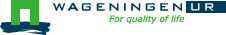



# Running a simulation with PCSE/LINTUL3

The LINTUL model (Light INTerception and UtiLisation) is a simple generic crop model, which simulates dry
matter production as the result of light interception and utilization with a constant light use efficiency.
In PCSE the LINTUL family of models has been implemented including the LINTUL3 model which is used for
simulation of crop production under water-limited and nitrogen-limited conditions.

For the third example, we will use LINTUL3 for simulating spring-wheat in the Netherlands under water-limited
and nitrogen-limited conditions. For the example we will assume that data files are in the `data` directory within the directory where this notebook is located. This will be the case if you downloaded the notebooks from github.

First we will import the necessary modules and define the data directory. We assume that you have the `pcse`, `matplotlib` and `pandas` packages installed on your system. 


In [8]:
%matplotlib inline
import os, sys
import pcse
import matplotlib.pyplot as plt
import pandas as pd
import yaml

data_dir = os.path.join(os.getcwd(), "data")
import pcse
print("This notebook was built with:")
print("python version: %s " % sys.version)
print("PCSE version: %s" %  pcse.__version__)

This notebook was built with:
python version: 2.7.14 |Anaconda, Inc.| (default, Nov  8 2017, 13:40:13) [MSC v.1500 32 bit (Intel)] 
PCSE version: 5.3.2


## Input requirements

For running the PCSE/LINTUL3 (and PCSE models in general), you need three types of inputs:
1. Model parameters that parameterize the different model components. These parameters usually
   consist of a set of crop parameters (or multiple sets in case of crop rotations), a set of soil parameters
   and a set of site parameters. The latter provide ancillary parameters that are specific for a location.
2. Driving variables represented by weather data which can be derived from various sources.
3. Agromanagement actions which specify the farm activities that will take place on the field that is simulated
   by PCSE. For defining the agromanagement we will use the new `AgroManager` which replaces the `timerdata`
   definition that was used previously.

Reading model parameters
------------------------
Model parameters can be easily read from the input files using the `PCSEFileReader`. However, PCSE models expect a single set of parameters and therefore they need to be combined using the
`ParameterProvider`::


In [9]:
from pcse.fileinput import PCSEFileReader
from pcse.base_classes import ParameterProvider
crop = PCSEFileReader(os.path.join(data_dir, "crop", "lintul3_springwheat.crop"))
soil = PCSEFileReader(os.path.join(data_dir, "soil", "lintul3_springwheat.soil"))
site = PCSEFileReader(os.path.join(data_dir, "site", "lintul3_springwheat.site"))
parameterprovider = ParameterProvider(soildata=soil, cropdata=crop, sitedata=site)

Reading weather data
--------------------
For reading weather data we will use the ExcelWeatherDataProvider. This WeatherDataProvider uses nearly the same
file format as is used for the CABO weather files but stores its data in an MicroSoft Excel file which makes the
weather files easier to create and update:

In [10]:
from pcse.fileinput import ExcelWeatherDataProvider
weatherdataprovider = ExcelWeatherDataProvider(os.path.join(data_dir, "meteo", "nl1.xlsx"))
print(weatherdataprovider)

Weather data provided by: ExcelWeatherDataProvider
--------Description---------
Weather data for:
Country: Netherlands
Station: Wageningen, Location Haarweg
Description: Observed data from Station Haarweg in Wageningen
Source: Meteorology and Air Quality Group, Wageningen University
Contact: Peter Uithol
----Site characteristics----
Elevation:    7.0
Latitude:  51.970
Longitude:  5.670
Data available for 2004-01-02 - 2008-12-31
Number of missing days: 32



Defining agromanagement
---------------------------
Defining agromanagement needs a bit more explanation because agromanagement is a relatively
complex piece of PCSE. The agromanagement definition for PCSE is written in a format called `YAML` and
for the current example looks like this:

    Version: 1.0
    AgroManagement:
    - 2006-01-01:
        CropCalendar:
            crop_name: wheat
            variety_name: spring-wheat-1
            crop_start_date: 2006-03-31
            crop_start_type: emergence
            crop_end_date: 2006-08-20
            crop_end_type: earliest
            max_duration: 300
        TimedEvents:
        -   event_signal: apply_n
            name:  Nitrogen application table
            comment: All nitrogen amounts in g N m-2
            events_table:
            - 2006-04-10: {amount: 10, recovery: 0.7}
            - 2006-05-05: {amount:  5, recovery: 0.7}
        StateEvents: null

The agromanagement definition starts with `Version:` indicating the version number of the agromanagement file
while the actual definition starts after the label `AgroManagement:`. Next a date must be provide which sets the
start date of the campaign (and the start date of the simulation). Each campaign is defined by zero or one
CropCalendars and zero or more TimedEvents and/or StateEvents. The CropCalendar defines the crop type, date of sowing,
date of harvesting, etc. while the Timed/StateEvents define actions that are either connected to a date or
to a model state.

In the current example, the campaign starts on 2006-01-01, there is a crop calendar for spring-wheat starting on
2006-03-31 with a harvest date of 2006-08-20 or earlier if the crop reaches maturity before this date.
Next there are timed events defined for applying N fertilizer at 2006-04-10 and 2006-05-05. The current example
has no state events. For a thorough description of all possibilities see the section on AgroManagement in the
Reference Guide.

Loading the agromanagement definition must by done with the YAMLAgroManagementReader::


In [11]:
from pcse.fileinput import YAMLAgroManagementReader
agromanagement = YAMLAgroManagementReader(os.path.join(data_dir, "agro", "lintul3_springwheat.agro"))
print(agromanagement)

!!python/object/new:pcse.fileinput.yaml_agmt_loader.YAMLAgroManagementReader
listitems:
- 2006-01-01:
    CropCalendar:
      crop_end_date: 2006-10-20
      crop_end_type: earliest
      crop_name: spring-wheat
      crop_start_date: 2006-03-31
      crop_start_type: emergence
      max_duration: 300
      variety_name: spring-wheat-1
    StateEvents: null
    TimedEvents:
    - comment: All nitrogen amounts in g N m-2
      event_signal: apply_n
      events_table:
      - 2006-04-10:
          amount: 10
          recovery: 0.7
      - 2006-05-05:
          amount: 5
          recovery: 0.7
      name: Nitrogen application table



## Starting and running the LINTUL3 model
We have now all parameters, weather data and agromanagement information available to start the LINTUL3 model:

In [12]:
from pcse.models import LINTUL3
lintul3 = LINTUL3(parameterprovider, weatherdataprovider, agromanagement)
lintul3.run_till_terminate()

## Getting and visualizing results

Next, we can easily get the output from the model using the get_output() method and turn it into a pandas DataFrame:

In [13]:
output = lintul3.get_output()
df = pd.DataFrame(output).set_index("day")
df.tail()

,DVS,LAI,NUPTT,TAGBM,TGROWTH,TIRRIG,TNSOIL,TRAIN,TRAN,TRANRF,TRUNOF,TTRAN,WC,WLVD,WLVG,WRT,WSO,WST
day,,,,,,,,,,,,,,,,,,
2006-07-28,1.931748,0.384372,4.705364,560.215659,626.055845,0.0,11.794636,375.4,0.0,0.0,0.0,71.142134,0.198576,88.549063,17.687187,16.649864,184.992749,268.986661
2006-07-29,1.953592,0.368403,4.705364,560.215659,626.055845,0.0,11.794636,376.3,0.0,0.0,0.0,71.142134,0.197346,89.285040,16.951210,16.150368,184.992749,268.986661
2006-07-30,1.974029,0.353714,4.705364,560.215659,626.055845,0.0,11.794636,376.3,0.0,0.0,0.0,71.142134,0.196293,89.962501,16.273749,15.665857,184.992749,268.986661
2006-07-31,1.995291,0.339132,4.705364,560.215659,626.055845,0.0,11.794636,381.6,0.0,0.0,0.0,71.142134,0.198484,90.635453,15.600797,15.195881,184.992749,268.986661
2006-08-01,2.000000,0.326168,4.705364,560.215659,626.055845,0.0,11.794636,381.7,0.0,0.0,0.0,71.142134,0.197384,91.234076,15.002174,14.740005,184.992749,268.986661


Finally, we can visualize the results from the pandas DataFrame with a few commands:

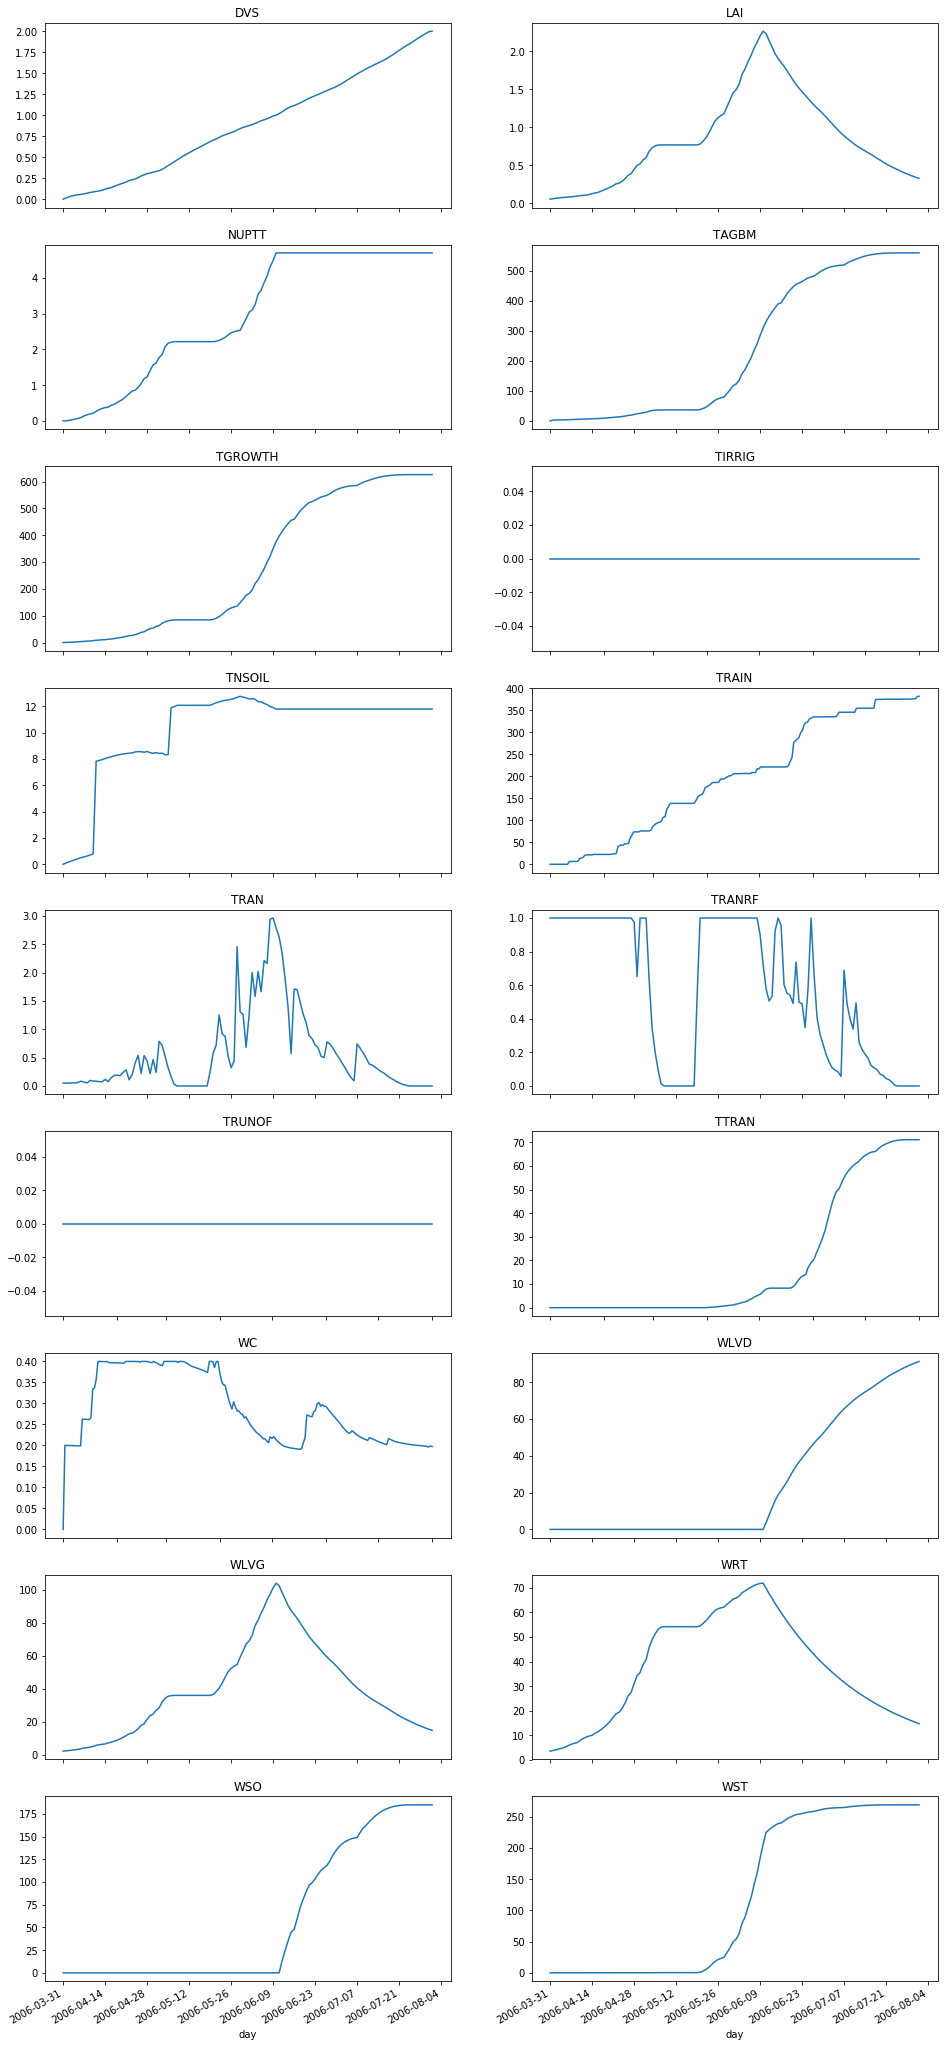

In [14]:
fig, axes = plt.subplots(nrows=9, ncols=2, figsize=(16,40))
for key, axis in zip(df.columns, axes.flatten()):
    df[key].plot(ax=axis, title=key)
fig.autofmt_xdate()